In [185]:
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances
import seaborn as sns
import torch

In [186]:
import pandas as pd
import numpy as np

In [279]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Generate test data

In [490]:
N_points = 20
N_features = 2

In [491]:
X, y = make_blobs(n_samples=N_points, n_features=N_features)

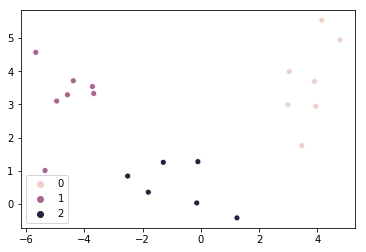

In [492]:
sns.scatterplot(X[:, 0], X[:, 1], hue=y)

In [493]:
D = pairwise_distances(X)

In [494]:
# extremely slow
def compute_opt(dist, coords, features):
    error = torch.tensor(0).type(torch.float32)
    
    for i in range(N_points):
        for j in range(N_points):
            if i == j:
                continue
            
            local_error = dist[i, j] ** 2 
            for k in range(features):
                local_error -= torch.abs(coords[i, k] - coords[j, k])
            
            error += local_error**2
    return error / (N_points ** 2)


def compute_opt_matrix(dist, coords):
    N_coords = coords.shape[0]
    ones_tensor = torch.ones(N_coords).type(torch.float32).reshape(1, -1)
    ones_tensor.requires_grad = False
    
    A = torch.mm(coords[:, 0].reshape(-1, 1), ones_tensor)
    B = torch.mm(coords[:, 1].reshape(-1, 1), ones_tensor)
    
    C = torch.transpose(A, 0, 1) - A
    R = torch.transpose(B, 0, 1) - B
    
    C = torch.mul(C, C)
    R = torch.mul(R, R)
    
    D = torch.mul(dist, dist)
    
    K = D - C - R
    
    return torch.mean(torch.mul(K, K))
    

In [495]:
puni = torch.distributions.Uniform(-2, 2)

X_t = puni.sample(sample_shape=[N_points, 2]).type(torch.float32)
D_t = torch.from_numpy(D).type(torch.float32)

X_t.requires_grad = True
D_t.requires_grad = False

for i in range(1, 1000):
    E = compute_opt_matrix(D_t, X_t)
    E.backward()
    
    with torch.no_grad():
        X_t -= 0.01*X_t.grad;
    
    X_t.requires_grad = True
    D_t.requires_grad = False
    
    X_t.grad = None
print(E)

tensor(3.4481e-10, grad_fn=<MeanBackward1>)


In [496]:
X_n = X_t.detach().numpy()

# Relative coordinates were recovered

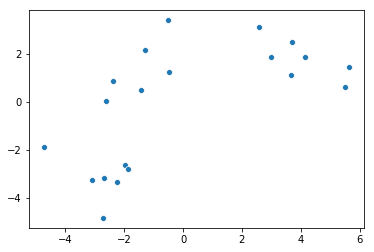

In [497]:
sns.scatterplot(X_n[:, 0], X_n[:, 1])

# Example with confusion matrix

In [498]:
D = pd.read_excel("/Users/ppogorelov/Downloads/confusion.xls")
D = D.set_index('name')
D = D.values.astype(float)

D = 1 - (D.T / D.sum(1)).T
np.fill_diagonal(D, 0)
N_points = D.shape[0]

In [499]:
puni = torch.distributions.Uniform(-2, 2)

X_t = puni.sample(sample_shape=[N_points, 2]).type(torch.float32)
D_t = torch.from_numpy(D).type(torch.float32)

X_t.requires_grad = True
D_t.requires_grad = False

for i in range(1, 500):
    E = compute_opt_matrix(D_t, X_t)
    E.backward()
    
    with torch.no_grad():
        X_t -= 0.01*X_t.grad;
    
    X_t.requires_grad = True
    D_t.requires_grad = False
    
    X_t.grad = None
print(E)

tensor(0.6719, grad_fn=<MeanBackward1>)


# Looks like a mess, maybe replace euclidean distance with cosine distance

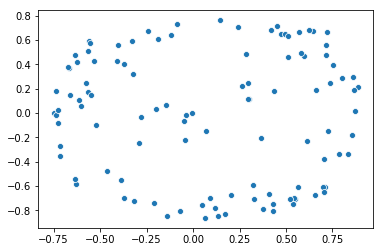

In [500]:
X_n = X_t.detach().numpy()
sns.scatterplot(X_n[:, 0], X_n[:, 1])